In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import expm
from transforms3d.euler import mat2euler

In [685]:
class EKF_SLAM():
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def __init__(self):
        """
            Function to initialize required necessary variable
            Also initialize the SLAM world
        """
        self.t = 0                                             # Time stamp of the camera
        self.linear_velocity = 0                               # Linear Velocity of the Camer
        self.angular_velocity = 0                              # Angular velocity of the Camera
        self.K = 0                                             # Calibration Matrix of the camera
        self.Ks = 0                                            # Full calibration matric of stereo camera
        self.b = 0                                             # Baseline of the stereo camera
        self.imu_T_cam = 0                                     # extrinsic matrix from (left)camera to imu, in SE(3)
        
        self.features = 0                                      # Features of the Landmark (kind-off edges)
        self.vland = []                                        # Features visible at partiuclar time
        self.oland = np.asarray([])                            # Total number of observed features
        self.nland = []                                        # Total number of new features
        self.uland = []                                        # What all features I have to update at a particular timestamp
        self.N_t = 0                                           # Number of features that needs to get updated
        
        self.c_time = 0                                        # This is like on which time we are currently in          
        self.z_numerator = 0                                   # A constant we don't have to calculate every time      
        
        self.M = 0                                             # Total number of Landmarks
        self.N = 0                                             # Total number of timestamps
        
        self.world_T_imu = 0                                   # This is the initial IMU pose of the system         
        self.dead_T = 0                                        # Read reckoning of the IMU
        self.imu_mu = 0                                        # Position of the m landmarks
        self.imu_covarinace = 0                                # Covaraince of this landmarks
        self.imu_V = 0                                         # IMU 
        self.tau = 0                                           # Time difference at time t
        self.u = 0                                             # This is the stack of linear and angular velocity R^6
        
        self.z_tilt = 0                                        # Expected Z of landmark
        self.m_mu = 0                                          # Landmark associated with observation zt
        self.m_covariance = 0                                  # Landmark associated with observation zt
        self.C = 1                                             # Supporter for covariance
        self.m_W = 0                                           # This is the Motion Noise
        self.m_V = 0                                           # This is the observation Noise
        self.V = 1                                             # V is a number multiplied by self.m_V
        self.H = 0                                             # This is the Jacobian matrix        
        self.Kg = 0                                            # This is the Kalman Gain Matrix
        self.P = 0                                             # Supporting matrix for H Jacobian
        self.skip = 16                                          # How many features should we take
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def visualize_trajectory_2d(self, dead=False, landmarks=False, path_name="Trajectory", show_ori=False):
        '''
        function to visualize the trajectory in 2D
        Input:
            pose:   4*4*N matrix representing the camera pose, 
                    where N is the number of poses, and each
                    4*4 matrix is in SE(3)
        '''        
        
        fig,ax = plt.subplots(figsize=(10,10))
        n_pose = self.world_T_imu.shape[0]
        ax.plot(self.world_T_imu[:, 0, 3], self.world_T_imu[:, 1, 3], 'r-', label=path_name)
        ax.scatter(self.world_T_imu[ 0, 0, 3], self.world_T_imu[ 0, 1, 3], marker='s', label="start")
        ax.scatter(self.world_T_imu[-1, 0, 3], self.world_T_imu[-1, 1, 3], marker='o', label="end")
        
        if landmarks:
            landmarks = self.m_mu.reshape((self.M, 3))
            x, y = landmarks[:, 0], landmarks[:, 1]
            ax.scatter(x, y, s=2, label="landmark")
            
        if dead:
            ax.plot(self.dead_T[:, 0, 3], self.dead_T[:, 1, 3], 'r-', label="Dead Reckoning")
            ax.scatter(self.dead_T[ 0, 0, 3], self.dead_T[ 0, 1, 3], marker='s', label="start dead")
            ax.scatter(self.dead_T[-1, 0, 3], self.dead_T[-1, 1, 3], marker='o', label="end dead")

        if show_ori:
            select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
            yaw_list = []

            for i in select_ori_index:
                _,_,yaw = mat2euler(self.world_T_imu[i, :3, :3])
                yaw_list.append(yaw)

            dx = np.cos(yaw_list)
            dy = np.sin(yaw_list)
            dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
            ax.quiver(self.world_T_imu[select_ori_index, 0, 3], self.world_T_imu[select_ori_index, 1, 3],dx,dy,\
                color="b",units="xy",width=1)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.axis('equal')
        ax.grid(False)
        ax.legend()
        plt.show(block=True)

        return fig, ax
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_stereo_matrix(self):
        """
            This function will initialize the stereo matrix from calibration matrix that is given to use
        """
        zeros_4 = np.zeros((1, 4))
        zeros_4[0, 2] = -1*self.z_numerator
        
        K_L = K_R = self.K[0:2]
        self.Ks = np.concatenate((K_L, K_R))
        self.Ks = np.concatenate((self.Ks, zeros_4.T), axis=1)
        return
        
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_imu_pose(self):
        """
            This function is used to find the initial pose of the IMU
            We start the IMU at [I, 0; 0, 0]
            Input:
            Output: Inital IMU Pose of R^(4x4)
        """
        self.world_T_imu = np.array([np.identity(4)])
        self.dead_T =  np.array([np.identity(4)])
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_imu_mu(self):
        """
        This function will initialize the IMU Mean (MU)
        """
        self.imu_mu = np.identity(4)
        return


    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_matrix_p(self):
        """
            This function will initialize the matrix P
            Input:
            Output:
        """
        identity = np.identity(3)
        zeros_3 = np.zeros((1, 3))
        self.P = np.concatenate((identity, zeros_3))
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_feature_reduction(self):
        """
            This function will reduce to the features according to the skips that we have defined before
        """
        _, self.M, self.N = self.features.shape
        self.M = np.ceil(self.M/self.skip).astype(int)                   # We will skip features so reducing size of M
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_m_mu(self):
        """
        This function will initialize the Landmark Mean (MU)
        """
        self.m_mu = np.full((3*self.M), np.nan)
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_m_covariance(self):
        """
        This function will initialize the Landmark Co (MU)
        """
        self.m_covariance = self.C*np.identity(3*self.M)
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def projection(self, q):
        """
            This function is used to find the projection pi of a matrix
            Input: q matrix
            Output: 
        """
        return (q / q[2])
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def derivative_projection(self, q):
        """
            This function is used to find the derivate of the 4x1 matrix i.e. q
            Kinda a supporting function for create_Jacobian_H
            Input: q belong to R^4
            Output: dpi/dq belong to R^(4x4)
        """
        d_pi_by_d_q = (1 / q[2]) * np.array([[1,    0, -q[0]/q[2],    0],
                                             [0,    1, -q[1]/q[2],    0],
                                             [0,    0,          0,    0],
                                             [0,    0, -q[3]/q[2],    1]])
        return d_pi_by_d_q
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def make_hat_of_vector(self, x):
        """
            This function is used to find the hat map of the R^3 vecotr
            Input: x belongs to R^3
            Ouput: x_hat belongs to R^(3x3)
        """
        x_hat = np.array([[    0, -x[2],  x[1]],
                          [ x[2],     0, -x[0]],
                          [-x[1],  x[0],     0]])
        return x_hat
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def get_control_unit(self, velocity, omega):
        """
            This method is used to find tyhe control of the IMU
            It belongs to R^6
            First R^3 is linear velocity
            Latter R^3 is angualr velocity
        """
        # The control unit of the motion model is [V, W] which is R^6        
        control = []
        control.extend(velocity)
        control.extend(omega)
        control = np.asarray(control)
        # print(); print("Control"); print(control)        
        return control
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def get_control_unit_hat(self, velocity, omega_hat):
        """
            This function is used to find hat map of the Control
            This becomes 4x4 matrix
            Input:
            Output: Returns the Hat-Map of the control given to IMU
        """
        zeros_4 = np.zeros((1, 4))
        velocity = np.array([velocity])
        control_unit_hat = np.concatenate((omega_hat, velocity.T), axis=1)
        control_unit_hat = np.concatenate((control_unit_hat, zeros_4))
        # print(); print("Control Unit Hat"); print(control_unit_hat.shape); print(control_unit_hat)
        
        return control_unit_hat 
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def get_control_unit_curly_hat(self, velocity_hat, omega_hat):
        """
            This function is used to find curly hat map of the Control
            This becomes 6x6 matrix
            Input:
            Output: Returns the Hat-Map of the control given to IMU
        """
        zeros_3 = np.zeros((3, 3))
        last_row_blocks = np.concatenate((zeros_3, omega_hat), axis=1)
        
        control_curly_hat = np.concatenate((omega_hat, velocity_hat), axis=1)
        control_curly_hat = np.concatenate((control_curly_hat, last_row_blocks))
        # print(); print("Control Unit Curly Hat"); print(control_curly_hat.shape); print(control_curly_hat)
        return control_curly_hat
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def circle_hat(self, s):
        """
            This function is used to find the circel hat of the function
            Input: Vector 4x1
            Output: Matrix 4x6
        """
        s_hat = self.make_hat_of_vector(s[:3])
        indentity_3 = np.identity(3)
        zeros_6 = np.zeros((1, 6))
        
        circle_s = np.concatenate((indentity_3, s_hat), axis=1)
        circle_s = np.concatenate((circle_s, zeros_6))
        return circle_s
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def load_data(self, file_name):
        '''
            Function to read visual features, IMU measurements and calibration parameters
        '''
        with np.load(file_name) as data:
            self.t = data["time_stamps"] # time_stamps
            self.features = data["features"] # 4 x num_features : pixel coordinates of features
            self.linear_velocity = data["linear_velocity"] # linear velocity measured in the body frame
            self.angular_velocity = data["angular_velocity"] # angular velocity measured in the body frame
            self.K = data["K"] # intrindic calibration matrix
            self.b = data["b"] # baseline
            self.imu_T_cam = data["imu_T_cam"] # Transformation from left camera to imu frame
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_initial_data(self):
        """
            This funcion will initialize IMU Pose, MU, SIGMA
            Also it will Initialize LANDMAKR MU, SIGMA
        """
        # Flips the sign of linear and angular velocity
        # self.linear_velocity[1:3, :] = -self.linear_velocity[1:3, :]
        # self.angular_velocity[1:3, :] = -self.angular_velocity[1:3, :]
        
        
        # Initialize Everything related to Camera
        self.z_numerator = self.K[0, 0]*self.b
        self.initialize_stereo_matrix()
        
        # Initialize Everything related to IMU
        self.initialize_imu_pose()
        self.initialize_imu_mu()
        self.initialize_imu_covarinace()
        self.initialize_imu_noise()
        
        # Initialize Everything related to Landmark
        self.initialize_matrix_p()
        self.initialize_feature_reduction()
        self.initialize_m_mu()
        self.initialize_m_covariance()
        self.get_Pw_landmark()
        self.update_new_m_mu()
        return
        
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####    
    def update_new_m_mu(self):
        """
            This function will get the world coordinates of the visible landmark
            From the 'get_Pw_landmark' method
            
            At time t=0 as the map is empty it will just initialize the particle
            And place those values in our bigger map i.e. self.m_mu
        """
        nland_pos_mu = []
        for i in range(3):
            nland_pos_mu.extend((self.nland*3)+i)
        nland_pos_mu = np.unique(nland_pos_mu)                           # Get Position for m_mu        
        nland_pos_Pw = np.where(np.in1d(self.vland, self.nland))[0]      # Get Position for Pw
        self.m_mu[nland_pos_mu] = self.Pw[:3, nland_pos_Pw].reshape((1, -1), order='F')
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def get_updated_m(self):
        """
            This function will find the small 'm' from the visible landmarks
        """
        self.vl_3 = []
        self.vl_4 = []
        for i in range(0, 3):
            self.vl_3.extend((self.uland*3)+i)
        for i in range(0, 4):
            self.vl_4.extend((self.uland*4)+i)
        self.vl_3 = np.unique(self.vl_3)
        self.vl_4 = np.unique(self.vl_4)
        
        uland_pos_Pw = np.where(np.in1d(self.vland, self.uland))[0]      # Get Position for Pw
        # print("\nIn get Update m")
        # print("U land: ", self.uland); print("VL 3: ", self.vl_3); print("VL 4: ", self.vl_4); print("Pos: ", uland_pos_Pw)
        Oo = np.ones((1, self.N_t))
        self.m_mu_bar = self.m_mu[self.vl_3].reshape((3, self.N_t), order='F')
        self.m_mu_bar = np.concatenate((self.m_mu_bar, Oo)).reshape((4*self.N_t), order='F')
        
        z = self.Pw[:, uland_pos_Pw].reshape((4*self.N_t), order='F')
        return z
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####    
    def get_Pw_landmark(self):
        """
            This function will get the world landmark position of the features that are visible
            It will also update
            1. self.vland
            2. self.uland
            3. self.nland
            4. self.oland
            
            5. self.Po                                                 # (X, Y, Z) Coordinates in Optical Frame    
            5. self.Pw                                                 # (X, Y, Z) Coordinates in World Frame    
        """
        w_T_i = self.imu_mu                                            # Pose of IMU
        i_T_o = self.imu_T_cam                                         # Pose of camera in imu frame
        w_T_o = w_T_i @ i_T_o
        
        # Feature selection
        cland = self.features[:, ::self.skip, self.c_time]             # This means current landmark
        self.vland = np.where((cland[0, :]!=-1) & (cland[1, :]!=-1) & (cland[2, :]!=-1) & (cland[3, :]!=-1))[0]
        
        # Let's find the important features
        self.uland = []                                                 # This is update landmark
        self.nland = []                                                 # This is new landmark
        self.oland = self.oland.tolist()                                # This is observed landmark
        for i in self.vland: # 10
            if i in self.oland:
                self.uland.append(i)
            else:
                self.nland.append(i)
                self.oland.append(i)
        self.uland = np.asarray(self.uland)                             # This is update landmark
        self.nland = np.asarray(self.nland)                             # This is new landmark
        self.oland = np.asarray(self.oland)                             # This is observed landmark
        self.N_t = len(self.uland)
        # print(); print("U Land: ", self.uland); print("N Land: ", self.nland); print("O Land: ", self.oland);
        cland = cland[:, self.vland]
        
        # Get the world coordinates of this visible landmarks
        ul, vl, ur, vr = cland
        d = ul - ur
        Zo = np.divide(self.z_numerator, d)
        Xo = np.multiply(Zo, np.divide((ul-self.K[0, 2]), self.K[0, 0]))
        Yo = np.multiply(Zo, np.divide((vl-self.K[1, 2]), self.K[1, 1]))
        Oo = np.ones((Xo.shape))        
        self.Po = np.vstack((Xo, Yo, Zo, Oo))                            # (X, Y, Z) Coordinates in Optical Frame
        self.Pw = w_T_o @ self.Po                                # (X, Y, Z) Coordintes in World Frame
        return
            
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def create_KalmanGain(self):
        """
            This function is used to find the Kalman Gain of the EKF
            Input: 
            Ouput:
        """
        # let's find the sub covariance of the m_covariance in order to reduce time
        self.row_s_cv = np.tile(self.vl_3, (3*self.N_t, 1)).reshape((-1, 1), order='F')
        self.col_s_cv = np.tile(self.vl_3, (3*self.N_t, 1)).reshape((-1, 1))
        
        self.sub_covariance = self.m_covariance[self.row_s_cv, self.col_s_cv].reshape((3*self.N_t, 3*self.N_t))
        
        # K_t_+_1 = Covarince * H.T * (H*Covarince*H.T + V)-1
        self.m_V = self.V*np.identity(4*self.N_t)
        inverse = np.linalg.inv((self.H @ self.sub_covariance @ self.H.T) + self.m_V)        
        self.Kg = self.sub_covariance @ self.H.T @ inverse
        # print(); print("Kalman Gain Kg"); print(self.Kg.shape); print(self.Kg)
        return 
            
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def create_Jacobian_H(self, o_T_w):
        """
            This function is used to find the Jacobian of the EKF
            Input: 
            Ouput: H belong to R(4Nx3M) and stored in self.H
        """        
        X = o_T_w @ self.P
        
        # It should be 4Nx3M    N=total number of visible features timestamp, M is landmarks
        self.H = np.zeros((4*self.N_t, 3*self.N_t))
        
        for i in range(self.N_t):
            # if i in self.visible_features_position[0]:
            q = o_T_w @ self.m_mu_bar[(i*4): ((i*4)+4)]
            d_pi_by_d_q = self.derivative_projection(q)
            self.H[(i*4): ((i*4)+4), (i*3): ((i*3)+3)] = self.Ks @ d_pi_by_d_q @ X
        # print(); print("Jacobian H"); print(self.H.shape); print(self.H)
        return
    
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def create_KalmanGain_imu(self):
        """
            This function is used to find the Kalman Gain of the EKF
            Input: 
            Ouput:
        """        
        # K_t_+_1 = Covarince * H.T * (H*Covarince*H.T + V)-1
        # self.m_V = (self.imu_V)*(np.kron(np.eye(self.N_t), np.ones((4, 4))))
        self.m_V = self.imu_V*np.identity(4*self.N_t)
        inverse = np.linalg.inv(((self.H_imu @ self.imu_covarinace @ self.H_imu.T) + self.m_V))  
        self.Kg_imu = self.imu_covarinace @ self.H_imu.T @ inverse
        return 
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def create_Jacobian_imu(self, o_T_w, o_T_i, i_T_w):
        """
            This function is used to find the Jacobian of the EKF
            Input: 
            Ouput: H belong to R(4Nx3M) and stored in self.H
        """        
        # It should be 4Nx6    
        self.H_imu = np.zeros((4*self.N_t, 6))      
        
        for i in range(self.N_t):
            mj = self.m_mu_bar[(i*4): ((i*4)+4)]
            q = o_T_w @ mj
            d_pi_by_d_q = self.derivative_projection(q)
            
            temp = i_T_w @ mj
            circle_temp = self.circle_hat(temp)
            self.H_imu[(i*4): ((i*4)+4), :] = self.Ks @ d_pi_by_d_q @ o_T_i @ circle_temp
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####    
    def motion_model_and_predict_step(self):
        """
            Function to predict the position of the IMU in the World Frame
            Input:
            Output:
        """
        # Increase the current time in predict step and update accordingly
        self.c_time = self.c_time + 1
        self.tau = self.t[0][self.c_time] - self.t[0][self.c_time - 1]
        
        # Manipulation on the control data
        velocity = self.linear_velocity[:, self.c_time]
        velocity_hat = self.make_hat_of_vector(velocity)
        omega = self.angular_velocity[:, self.c_time]
        omega_hat = self.make_hat_of_vector(omega)
        
        # All the necessary controls given to IMU
        control = self.get_control_unit(velocity, omega)
        control_hat = self.get_control_unit_hat(velocity, omega_hat)
        control_curly_hat = self.get_control_unit_curly_hat(velocity_hat, omega_hat)
        
        # IMU Pose update
        new_world_T_imu = self.world_T_imu[self.c_time-1]
        new_world_T_imu = np.asarray([new_world_T_imu@expm(self.tau*control_hat)])
        # print(); print("Updated world_T_imu"); print(new_world_T_imu)
        
        self.imu_mu = new_world_T_imu[0]
        self.imu_covarinace = expm(-1*self.tau*control_curly_hat)@self.imu_covarinace@expm(-1*self.tau*control_curly_hat).T + self.W
        # print(); print("Updated IMU"); print(self.imu_mu)
        
        # original_imu_pose = self.world_T_imu.tolist()
        # original_imu_pose.extend(new_world_T_imu)
        # self.world_T_imu = np.asarray(original_imu_pose)
        
        
        new_dead_T = self.dead_T[self.c_time-1]
        new_dead_T = np.asarray([new_dead_T@expm(self.tau*control_hat)])
        original_dead_T = self.dead_T.tolist()
        original_dead_T.extend(new_dead_T)
        self.dead_T = np.asarray(original_dead_T)
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def observation_model_and_update(self, pose_update=False):        
        self.get_Pw_landmark()
        
        # Update the values in m_mu for new features
        if len(self.nland) > 0:
            self.update_new_m_mu()
            
        # Create the landmark where we have to update the values
        if self.N_t > 0:
            w_T_i = self.imu_mu                                            # Pose of IMU
            i_T_o = self.imu_T_cam                                         # Pose of camera in imu frame
            i_T_w = np.linalg.inv(w_T_i)
            o_T_i = np.linalg.inv(i_T_o)
            w_T_o = w_T_i @ i_T_o                                          # Transformation from optical to world
            o_T_w = o_T_i @ i_T_w                                          # Transformation from world to optical
            
            if pose_update:            
            # Updating the value of the IMU
                z = self.get_updated_m()
                mu_bar = o_T_w @ self.m_mu_bar.reshape((4, slam.N_t), order='F')
                z_tilt = (self.Ks @ self.projection(mu_bar)).reshape((4*self.N_t), order='F')

                self.create_Jacobian_imu(o_T_w, o_T_i, i_T_w)
                self.create_KalmanGain_imu()
                whole = self.Kg_imu @ (z - z_tilt)
                indentity_6 = np.identity(6)
                vel = whole[:3]; omg = whole[3:]
                omg_hat = self.make_hat_of_vector(omg)
                new_hat = self.get_control_unit_hat(vel, omg_hat)
                self.imu_mu = self.imu_mu@expm(new_hat)
                part_a = indentity_6 - (self.Kg_imu @ self.H_imu)
                self.imu_covarinace = (part_a@self.imu_covarinace@part_a.T) + (self.Kg_imu@self.m_V@self.Kg_imu.T)
                
                self.get_Pw_landmark()
            
            # Updating the value of the Landmarks
            z = self.get_updated_m()                                    # Get all the visible landmarks to be updated
            mu_bar = o_T_w @ self.m_mu_bar.reshape((4, slam.N_t), order='F')
            z_tilt = (self.Ks @ self.projection(mu_bar)).reshape((4*self.N_t), order='F') 
            self.create_Jacobian_H(o_T_w)
            self.create_KalmanGain()
            self.m_mu[self.vl_3] = self.m_mu[self.vl_3] + self.Kg@(z - z_tilt)            
            part_a = np.identity(self.N_t*3) - (self.Kg @ self.H)
            self.sub_covariance = (part_a@self.sub_covariance@part_a.T) + (self.Kg@self.m_V@self.Kg.T)
            self.m_covariance[self.row_s_cv, self.col_s_cv] = self.sub_covariance.reshape(-1, 1)
            
            w_T_i = self.imu_mu                                            # Pose of IMU
            i_T_o = self.imu_T_cam                                         # Pose of camera in imu frame
            i_T_w = np.linalg.inv(w_T_i)
            o_T_i = np.linalg.inv(i_T_o)
            w_T_o = w_T_i @ i_T_o                                          # Transformation from optical to world
            o_T_w = o_T_i @ i_T_w                                          # Transformation from world to optical
            
            
        # Update the IMU pose List
        original_imu_pose = self.world_T_imu.tolist()
        original_imu_pose.extend(np.asarray([self.imu_mu]))
        self.world_T_imu = np.asarray(original_imu_pose)            
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_imu_covarinace(self):
        """
            This function will initialize the IMU Covaraince (SIGMA)
        """
        self.imu_covarinace = np.identity(6)
        return
    
    def initialize_imu_noise(self):
        """
            This function will initialize the IMU Noise (W)
        """
        self.W = np.multiply(1e-12, np.identity(6))
        return

Motion_Model: 100%|████████████████████████████████████████████████████████████████| 1008/1008 [00:10<00:00, 93.74it/s]


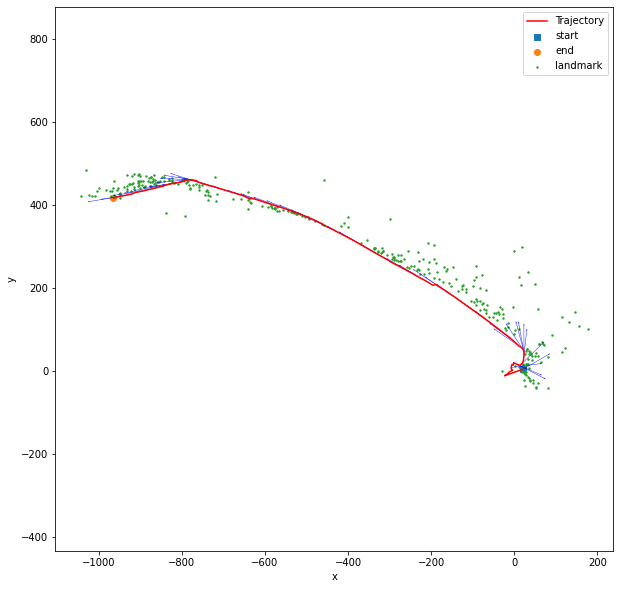

In [688]:
if __name__ == '__main__':
    # filename = "./data/10.npz"; n = 3026 - 1
    filename = "./data/03.npz"; n = 1010 - 1
    
    # Get the EKF_SLAM object
    slam = EKF_SLAM()                              # Get the slam object
    slam.load_data(filename)                       # Get the data using the slam objectX
    
    slam.C = 1                                    # Slam.C is multiplied by initial identity covariance matrix
    slam.V = 100                                    # slam.V is multiplied by Identity matrix to get noise
    slam.imu_V = 3                                # slam,imu_V is multiplied by identity matrix to get noise in motion model
    
    slam.initialize_initial_data()                 # Initialize the data
    slam.motion_model_and_predict_step()           # It is basically a predict step
    slam.observation_model_and_update(pose_update=True)            # It is basically a update step
    
    
    pbar = tqdm(desc="Motion_Model", total=n-1)               
    while slam.c_time < n:                 
        slam.motion_model_and_predict_step()
        slam.observation_model_and_update(pose_update=True)            # It is basically a update step
        pbar.update()
    pbar.close()
    
    slam.dead_T = slam.dead_T[1:]
    slam.world_T_imu = slam.world_T_imu[1:]
    fig, ax = slam.visualize_trajectory_2d(landmarks=True, show_ori=True)

In [637]:
# pbar.close()

In [682]:
folder_03 = "D:/University of California San Diego/Quater 2/ECE276A/Assignment 3/harsh_ece276a_pr3/code/images/03/"
folder_10 = "D:/University of California San Diego/Quater 2/ECE276A/Assignment 3/harsh_ece276a_pr3/code/images/10/"

In [639]:
img = "06.png"
fig.savefig(folder_03+img)

In [687]:
img = "04.png"
fig.savefig(folder_10+img)